### SQ1: Global Structure — Are There Stable Hard Cluster Boundaries?

**Goal**: In M3, I focus on SQ1 (global structure) to test whether Bob Ross paintings form stable, reproducible hard cluster boundaries based on binary pigment usage.

**How this differs from my M2**: My M2 analysis was primarily exploratory and descriptive, aimed at identifying potential groupings and interpreting palette patterns. In contrast, M3 reframes the same theme as a robustness question: are any apparent “archetypes” consistent across clustering choices (linkage, k) and feature variants (with vs. without Titanium White), or is the structure better described as continuous variation?

**Roadmap**: I (1) construct the pigment feature matrix, (2) compute pairwise Jaccard distances and build a baseline dendrogram, (3) run stability checks across linkage/k and with-vs-without Titanium White, (4) use PCA as a supporting visualization, and (5) summarize conclusions and limitations.

### Step 1 — Construct the Pigment Feature Matrix


In [4]:

import pandas as pd


df = pd.read_csv("/content/bob_ross.csv")

pigment_cols = df.columns[9:].tolist()
X = df[pigment_cols].copy()

print("Data shape:", df.shape)
print("Pigment matrix shape:", X.shape)
print("Pigment columns:", pigment_cols)

is_binary = all(set(X[c].dropna().unique().tolist()).issubset({0, 1}) for c in pigment_cols)
print("All pigment columns are binary (0/1):", is_binary)

for c in pigment_cols:
    print(c, sorted(X[c].dropna().unique().tolist()))

Data shape: (403, 27)
Pigment matrix shape: (403, 18)
Pigment columns: ['Black_Gesso', 'Bright_Red', 'Burnt_Umber', 'Cadmium_Yellow', 'Dark_Sienna', 'Indian_Red', 'Indian_Yellow', 'Liquid_Black', 'Liquid_Clear', 'Midnight_Black', 'Phthalo_Blue', 'Phthalo_Green', 'Prussian_Blue', 'Sap_Green', 'Titanium_White', 'Van_Dyke_Brown', 'Yellow_Ochre', 'Alizarin_Crimson']
All pigment columns are binary (0/1): True
Black_Gesso [False, True]
Bright_Red [False, True]
Burnt_Umber [False, True]
Cadmium_Yellow [False, True]
Dark_Sienna [False, True]
Indian_Red [False, True]
Indian_Yellow [False, True]
Liquid_Black [False, True]
Liquid_Clear [False, True]
Midnight_Black [False, True]
Phthalo_Blue [False, True]
Phthalo_Green [False, True]
Prussian_Blue [False, True]
Sap_Green [False, True]
Titanium_White [False, True]
Van_Dyke_Brown [False, True]
Yellow_Ochre [False, True]
Alizarin_Crimson [False, True]


### Step 2 — Compute Jaccard Distances and Build a Baseline Dendrogram

Jaccard distance is used to measure how similar two paintings are based on their pigment sets. Since each pigment feature is binary (used vs. not used), Jaccard focuses on shared pigment presence and ignores pigments that are absent in both paintings. A smaller Jaccard distance means two paintings use more of the same pigments, while a larger distance means their palettes overlap less.

Condensed distance shape: (81003,)
Square distance shape: (403, 403)
Mean Jaccard distance: 0.36538496737070536
Min/Max Jaccard distance: 0.0 1.0


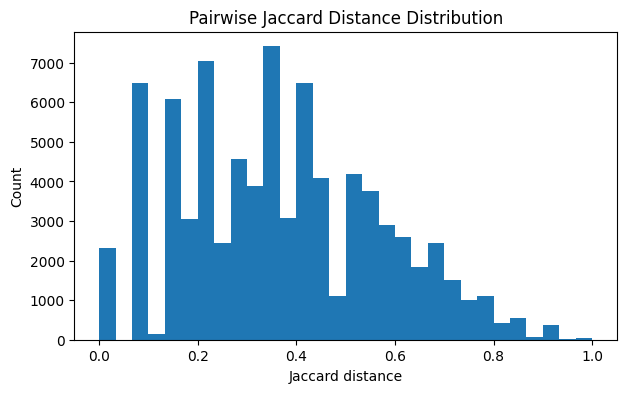

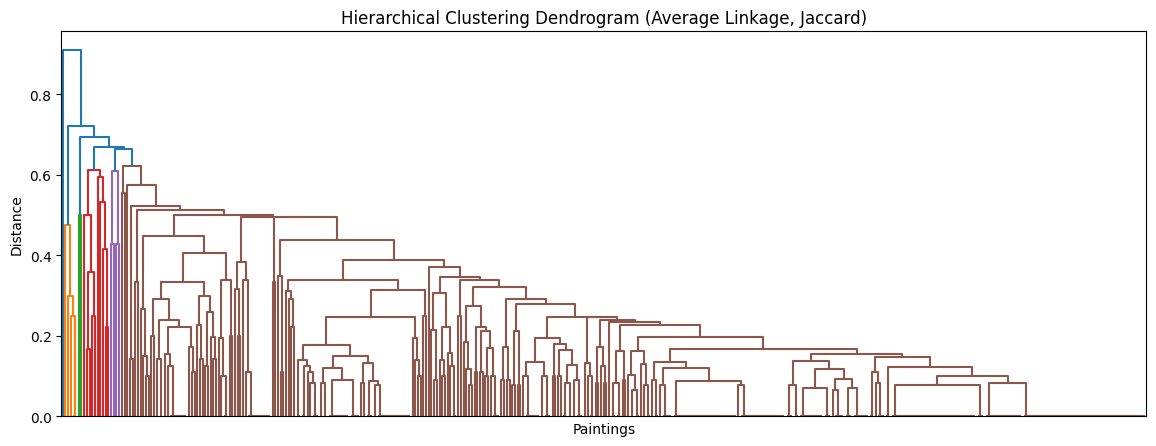

In [16]:
import numpy as np
import pandas as pd
from scipy.spatial.distance import pdist, squareform
from scipy.cluster.hierarchy import linkage, dendrogram
import matplotlib.pyplot as plt


D_condensed = pdist(X.values, metric="jaccard")
D_square = squareform(D_condensed)

print("Condensed distance shape:", D_condensed.shape)
print("Square distance shape:", D_square.shape)
print("Mean Jaccard distance:", D_condensed.mean())
print("Min/Max Jaccard distance:", D_condensed.min(), D_condensed.max())

plt.figure(figsize=(7,4))
plt.hist(D_condensed, bins=30)
plt.title("Pairwise Jaccard Distance Distribution")
plt.xlabel("Jaccard distance")
plt.ylabel("Count")
plt.show()

Z_avg = linkage(D_condensed, method="average")
plt.figure(figsize=(14,5))
dendrogram(Z_avg, no_labels=True, color_threshold=None)
plt.title("Hierarchical Clustering Dendrogram (Average Linkage, Jaccard)")
plt.xlabel("Paintings")
plt.ylabel("Distance")
plt.show()

I computed pairwise Jaccard distances between paintings to measure palette similarity for binary data. Then I examined the distance distribution and generated a baseline hierarchical clustering dendrogram using average linkage. This step provides an initial global view of whether palette patterns suggest clear hard boundaries or more continuous variation.

### Step 3 — Stability and Sensitivity Checks

We compare k=4 and k=6 as two reasonable cut levels for exploratory stability checks rather than to claim an optimal k.

In [19]:
import numpy as np
import pandas as pd
from scipy.spatial.distance import pdist
from scipy.cluster.hierarchy import linkage, fcluster
from sklearn.metrics import adjusted_rand_score, silhouette_score

pigment_cols = df.columns[9:].tolist()
X_full = df[pigment_cols].copy()

def run_cluster_eval(X, linkage_method, k):
    D = pdist(X.values, metric="jaccard")
    Z = linkage(D, method=linkage_method)
    labels = fcluster(Z, t=k, criterion="maxclust")
    sil = silhouette_score(X.values, labels, metric="jaccard")
    return labels, sil

results = []

for lm in ["average", "complete"]:
    for k in [4, 6]:
        labels, sil = run_cluster_eval(X_full, lm, k)
        results.append({
            "version": "with_TW",
            "linkage": lm,
            "k": k,
            "silhouette_jaccard": sil,
            "labels": labels
        })

tw_candidates = [c for c in X_full.columns if c.lower().replace(" ", "").replace("_","") in ["titaniumwhite", "titaniumwhite(1)"]]
if len(tw_candidates) == 0:
    tw_candidates = [c for c in X_full.columns if "titanium" in c.lower() and "white" in c.lower()]

if tw_candidates:
    tw_col = tw_candidates[0]
    X_no_tw = X_full.drop(columns=[tw_col]).copy()

    for lm in ["average", "complete"]:
        for k in [4, 6]:
            labels, sil = run_cluster_eval(X_no_tw, lm, k)
            results.append({
                "version": "without_TW",
                "linkage": lm,
                "k": k,
                "silhouette_jaccard": sil,
                "labels": labels
            })
else:
    print("Titanium White column not found; skipping without_TW comparison.")

summary = pd.DataFrame([{k:v for k,v in r.items() if k!="labels"} for r in results])
print(summary.sort_values(["version","linkage","k"]).to_string(index=False))


for k in [4, 6]:
    la = [r["labels"] for r in results if r["version"]=="with_TW" and r["linkage"]=="average" and r["k"]==k][0]
    lc = [r["labels"] for r in results if r["version"]=="with_TW" and r["linkage"]=="complete" and r["k"]==k][0]
    ari = adjusted_rand_score(la, lc)
    print(f"ARI (with_TW, average vs complete, k={k}): {ari:.4f}")


if any(r["version"]=="without_TW" for r in results):
    for lm in ["average", "complete"]:
        for k in [4, 6]:
            lw = [r["labels"] for r in results if r["version"]=="with_TW" and r["linkage"]==lm and r["k"]==k][0]
            ln = [r["labels"] for r in results if r["version"]=="without_TW" and r["linkage"]==lm and r["k"]==k][0]
            ari = adjusted_rand_score(lw, ln)
            print(f"ARI (with vs without TW, {lm}, k={k}): {ari:.4f}")

   version  linkage  k  silhouette_jaccard
   with_TW  average  4            0.470907
   with_TW  average  6            0.455069
   with_TW complete  4            0.351004
   with_TW complete  6            0.335955
without_TW  average  4            0.482794
without_TW  average  6            0.460355
without_TW complete  4            0.282925
without_TW complete  6            0.284907
ARI (with_TW, average vs complete, k=4): 0.1574
ARI (with_TW, average vs complete, k=6): 0.3670
ARI (with vs without TW, average, k=4): 0.6957
ARI (with vs without TW, average, k=6): 0.9469
ARI (with vs without TW, complete, k=4): 0.5416
ARI (with vs without TW, complete, k=6): 0.5106


In this step, I quantified how balanced the resulting clusters are under each setting (linkage choice, k cut, and with vs. without Titanium White). For each solution, I report the sample count per cluster and the proportion of the largest cluster. Highly imbalanced solutions (one dominant cluster plus several very small clusters) indicate weak global separability and suggest that hard boundaries may be driven by a few outliers rather than multiple stable archetypes.

In [17]:
import numpy as np
import pandas as pd


rows = []
for r in results:
    labels = r["labels"]
    counts = pd.Series(labels).value_counts().sort_index()
    max_prop = counts.max() / counts.sum()

    row = {
        "version": r["version"],
        "linkage": r["linkage"],
        "k": r["k"],
        "n_clusters": counts.shape[0],
        "max_cluster_size": int(counts.max()),
        "max_cluster_prop": float(max_prop)
    }

    for i, (cid, cnt) in enumerate(counts.items(), start=1):
        row[f"c{i}_size"] = int(cnt)

    rows.append(row)

cluster_balance = pd.DataFrame(rows).sort_values(["version","linkage","k"]).reset_index(drop=True)
display(cluster_balance)

,version,linkage,k,n_clusters,max_cluster_size,max_cluster_prop,c1_size,c2_size,c3_size,c4_size,c5_size,c6_size
0,with_TW,average,4,4,395,0.980149,5,2,395,1,NaN,NaN
1,with_TW,average,6,6,381,0.945409,5,2,10,4,381.0,1.0
2,with_TW,complete,4,4,331,0.821340,331,15,44,13,NaN,NaN
3,with_TW,complete,6,6,331,0.821340,331,14,1,44,6.0,7.0
4,without_TW,average,4,4,394,0.977667,6,2,394,1,NaN,NaN
5,without_TW,average,6,6,383,0.950372,6,2,2,9,383.0,1.0
6,without_TW,complete,4,4,315,0.781638,315,61,9,18,NaN,NaN
7,without_TW,complete,6,6,300,0.744417,15,300,6,55,9.0,18.0


In our results, the average-linkage solutions are extremely imbalanced: the largest cluster contains roughly 95–98% of paintings (e.g., max cluster proportion ≈ 0.98 for k=4 and ≈ 0.95 for k=6, both with and without Titanium White). The remaining clusters are very small, often containing only a handful of paintings. The complete-linkage solutions are less extreme but still dominated by one large cluster (about 82% of paintings). Overall, this pattern supports the interpretation that global hard cluster boundaries are weak; the data appear to contain one dominant palette region with a small number of peripheral or outlier groups rather than multiple well-separated archetypes.

### Step 4 — PCA Visualization for Cluster Interpretation

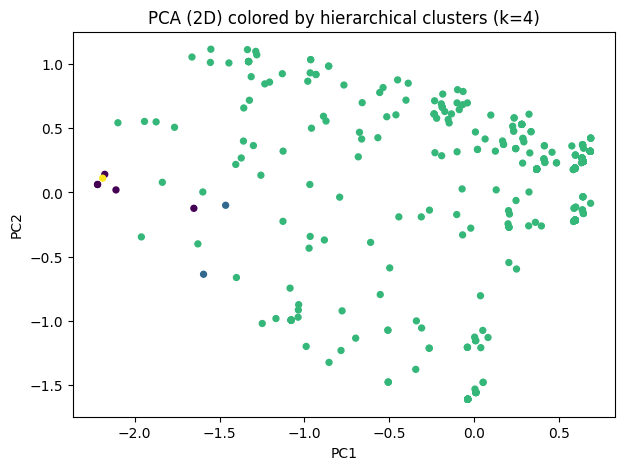

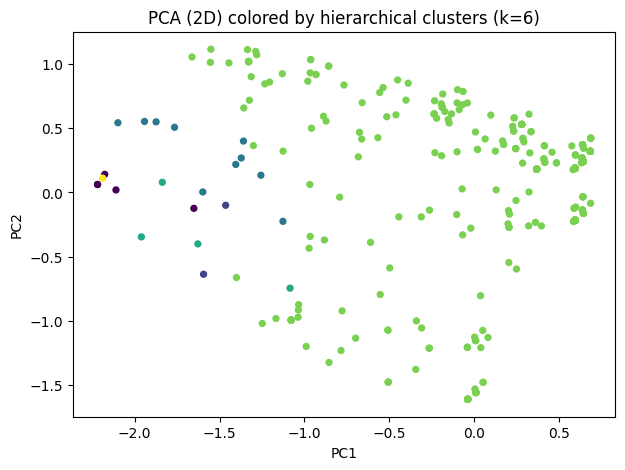

Explained variance ratio (PC1, PC2): [0.23180513 0.18630154]
Total explained variance (PC1+PC2): 0.41810666416849085


In [20]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from scipy.spatial.distance import pdist
from scipy.cluster.hierarchy import linkage, fcluster


D = pdist(X.values, metric="jaccard")
Z = linkage(D, method="average")
labels_k4 = fcluster(Z, t=4, criterion="maxclust")
labels_k6 = fcluster(Z, t=6, criterion="maxclust")

pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X.values)

plt.figure(figsize=(7,5))
plt.scatter(X_pca[:,0], X_pca[:,1], c=labels_k4, s=18)
plt.title("PCA (2D) colored by hierarchical clusters (k=4)")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.show()

plt.figure(figsize=(7,5))
plt.scatter(X_pca[:,0], X_pca[:,1], c=labels_k6, s=18)
plt.title("PCA (2D) colored by hierarchical clusters (k=6)")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.show()

print("Explained variance ratio (PC1, PC2):", pca.explained_variance_ratio_)
print("Total explained variance (PC1+PC2):", pca.explained_variance_ratio_.sum())

The PCA plots (k=4 and k=6) show substantial overlap among cluster labels rather than clear, isolated groups. Most paintings remain concentrated in one broad region, while only a small number of points appear as separated minorities. This indicates that cluster assignments are dominated by one large group with a few small peripheral groups, instead of balanced, well-separated hard clusters.

The first two principal components explain about 41.8% of total variance (PC1 ≈ 23.2%, PC2 ≈ 18.6%), which is enough for a useful visual summary but not enough to claim strict low-dimensional separability. Therefore, PCA supports the same conclusion from Step 3: global hard boundaries are weak, and the palette structure is better interpreted as continuous variation with limited local grouping.

### Step 5 — SQ1 Conclusion and Integration Link

Across robustness checks, cluster quality is moderate under average linkage but weaker under complete linkage, and cluster assignments can change noticeably with linkage choice. Comparing with vs. without Titanium White shows that some aspects of structure persist, but this does not create consistently strong global separation. PCA further indicates overlapping groups rather than distinct low-dimensional clusters.

**Conclusion** (SQ1): Overall, SQ1 provides limited support for strong, universally stable hard cluster boundaries. The global palette structure appears partially organized but not robustly separable into clear archetypes.